# Investigating the Panama Papers

This demo will show how to do simple data exploration using MLDB. We will use the the Offshore Leaks Database from [ICIJ](https://offshoreleaks.icij.org/). It contains data about offshore entities from the Panama Papers and the Offshore Leaks investigations. We will be showing off the capabilities of MLDB's SQL engine and how easy it is to create simple charts using a few external python libraries. Note that even though the data is coming from our servers, no transformation has been made to the original data: all the parsing and transformations are done here using MLDB.

**WARNING**: This demo requires 4GB of memory to run. If you are running this demo on VirtualBox, make sure enough memory is allocated to the virtual machine or the notebook may not run successfully.

In [1]:
from pymldb import Connection
mldb = Connection()

In [2]:
# loading some plotting libraries and setting some defaults
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15, 5
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'

from bokeh.charts import Line, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## Offshore Entities

When using real-life data to do data science, a lot of time is spend getting the data in the right format. In this example, the original date in the data is not formatted correctly to be parsed into a timestamp. This is something we need to easily extract the year from it later on. One very powerful feature of MLDB is the [`jseval`][1] function, that allows us to execute arbitrary JavaScript code inline in SQL. This allows us to use JavaScript's Date object to easily parse the date for us. The other columns are straightforwardly loaded by MLDB.

[1]: ../../../../doc/#builtin/sql/ValueExpression.md.html#builtinfunctions

In [3]:
data_dir = 'http://public.mldb.ai/datasets/offshore_leaks/'
print mldb.post("/v1/procedures", {
    "type": 'import.text',
    "params": {
        "dataFileUrl": data_dir + 'Entities.csv.gz',
        "delimiter": ',',
        "encoding": 'latin1',
        "runOnCreation": True,
        "outputDataset": 'entities_raw',
        "ignoreBadLines": True,
    }
})

print mldb.put('/v1/functions/parse_date', {
    'type': 'sql.expression',
    'params': {
        'expression': "jseval('return d ? new Date(d) : null;', 'd', date) as parsed_date"
    }
})

print mldb.post('/v1/procedures', {
    'type': 'transform',
    'params': {
        'inputData': """
            SELECT
                * EXCLUDING(incorporation_date, inactivation_date, struck_off_date, dorm_date),
                parse_date({date: incorporation_date})[parsed_date] AS incorporation_date,
                parse_date({date: inactivation_date})[parsed_date] AS inactivation_date,
                parse_date({date: struck_off_date})[parsed_date] AS struck_off_date,
                parse_date({date: dorm_date})[parsed_date] AS dorm_date
             FROM entities_raw
             """,
        'outputDataset': 'entities',
        'runOnCreation': True
        }
    })

<Response [201]>
<Response [201]>
<Response [201]>


This is what the created dataset looks like:

In [4]:
mldb.query("SELECT * FROM entities LIMIT 5")

,address,company_type,countries,country_codes,ibcRUC,incorporation_date,jurisdiction,jurisdiction_description,name,node_id,service_provider,sourceID,status,valid_until,inactivation_date,internal_id,original_name,struck_off_date
_rowName,,,,,,,,,,,,,,,,,,
234977,Portcullis TrustNet Chambers P.O. Box 3444 Roa...,Business Company Limited by Shares,British Virgin Islands,VGB,1019510,2006-04-03T00:00:00Z,BVI,British Virgin Islands,Signature Management International Limited,149976,Portcullis Trustnet,Offshore Leaks,Active,The Offshore Leaks data is current through 2010,None,NaN,None,None
212107,"FIGEST CONSEIL S.A. 20, RUE DU CONSEIL-GENERAL...",None,Switzerland,CHE,4742,1999-08-12T00:00:00Z,NIUE,Niue,SUNFLOWER S.A.,10212959,Mossack Fonseca,Panama Papers,Dissolved,The Panama Papers data is current through 2015,2005-01-19T00:00:00Z,900146,SUNFLOWER S.A.,2006-04-12T00:00:00Z
234971,Portcullis TrustNet Chambers P.O. Box 3444 Roa...,Business Company Limited by Shares,British Virgin Islands,VGB,1390171,2007-03-07T00:00:00Z,BVI,British Virgin Islands,Meilin Electronics Information Technology (HK)...,153611,Portcullis Trustnet,Offshore Leaks,Active,The Offshore Leaks data is current through 2010,None,NaN,None,None
234963,Portcullis TrustNet Chambers P.O. Box 3444 Roa...,Business Company Limited by Shares,British Virgin Islands,VGB,1019846,2006-04-04T00:00:00Z,BVI,British Virgin Islands,EWING TECHNOLOGIES LTD.,149954,Portcullis Trustnet,Offshore Leaks,Active,The Offshore Leaks data is current through 2010,None,NaN,None,None
225788,None,Standard International Company,British Virgin Islands,VGB,82919,1993-04-07T00:00:00Z,BVI,British Virgin Islands,PEIPUS INTERNATIONAL LIMITED,143357,Portcullis Trustnet,Offshore Leaks,Struck / Defunct / Deregistered,The Offshore Leaks data is current through 2010,None,NaN,None,None


We can now count the number of offshore companies per jurisdiction (the country when they are legally located).

                           count
_rowName                        
British Virgin Islands    151587
Panama                     48373
Bahamas                    15946
Seychelles                 15580
Samoa                      13418
Niue                        9611
British Anguilla            3253
Cook Islands                2637
Hong Kong                   1603
Nevada                      1260
Singapore                    740
Cayman                       668
Labuan                       423
United Kingdom               151
Belize                       130
Mauritius                     82
Cyprus                        79
Costa Rica                    78
Malaysia                      71
Uruguay                       52
New Zealand                   47
Jersey                        39
Wyoming                       37
Malta                         28
Liberia                       11
Isle Of Man                    8
Marshall Islands               6
Bermuda                        6
Vanuatu   

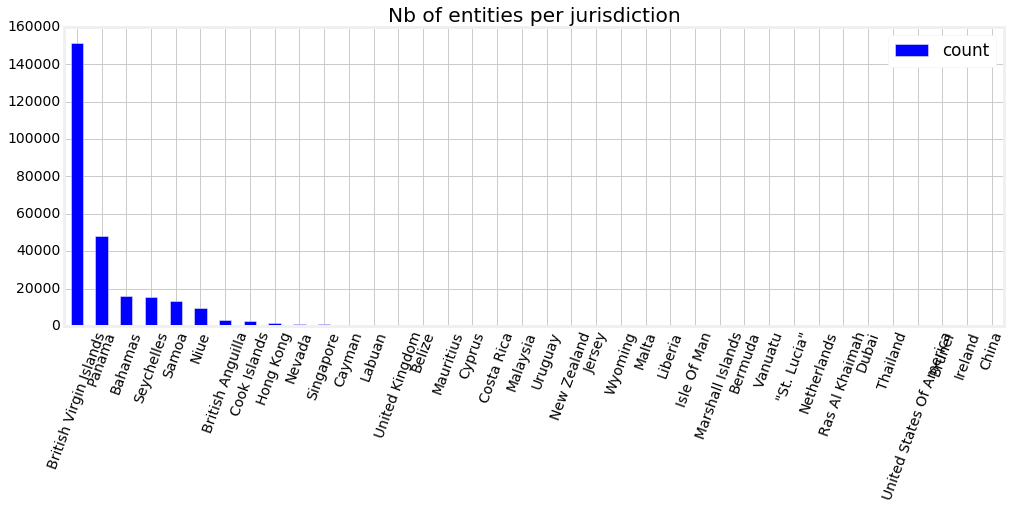

In [5]:
def bar_plot(dataframe, title='', print_table=True):
    """ plot the result of a query in a bar chart """
    if print_table:
        print dataframe
    ax = dataframe.plot(kind='bar')
    for tick in ax.get_xticklabels():
        tick.set_rotation(70)
    ax.set_title(title)
    ax.set_xlabel('')
    return ax

data = mldb.query("""
SELECT count(*) AS count
NAMED jurisdiction_description
FROM entities
WHERE jurisdiction != 'XXX'
GROUP BY jurisdiction_description
ORDER BY count DESC
""")
bar_plot(data, 'Nb of entities per jurisdiction')

We can also look at the number of offshore companies created each year. Here we use the [`date_part`](../../../../doc/#builtin/sql/ValueExpression.md.html#builtinfunctions) function to extract the year, and then we `GROUP BY` on that year and `count` the number of companies.

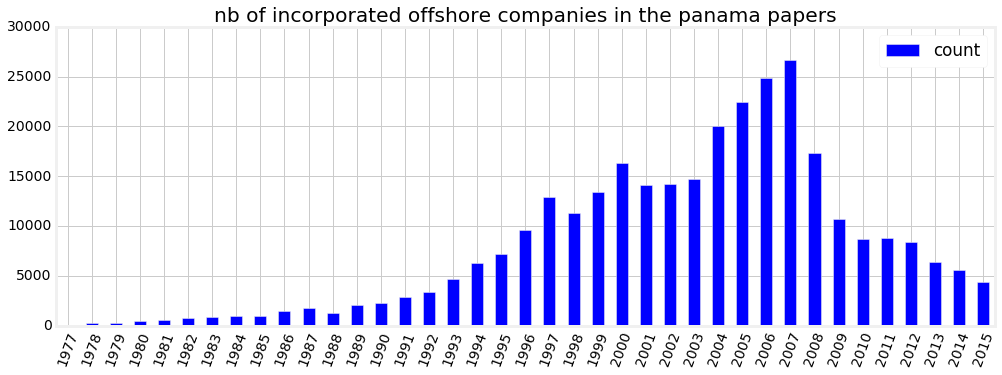

In [6]:
bar_plot(mldb.query("""
SELECT count(*) as count
NAMED year
FROM (
    SELECT date_part('year', incorporation_date) AS year
    FROM entities
    WHERE incorporation_date IS NOT NULL
)
WHERE year BETWEEN 1977 AND 2016
GROUP BY year
ORDER BY year
"""), title='nb of incorporated offshore companies in the panama papers', print_table=False)

We can do something similar but also group on the country, and see how many offshore companies were created per year per country. We only keep the top countries using a `IN` statement.

In [7]:
data = mldb.query("""
SELECT
    year, country, count(*) AS count
    FROM (
        SELECT date_part('year', incorporation_date) AS year,
               jurisdiction_description AS country
        FROM entities
        WHERE incorporation_date IS NOT NULL
              AND (jurisdiction_description IN (
                SELECT jurisdiction_description
                FROM entities
                WHERE jurisdiction != 'XXX'
                GROUP BY jurisdiction_description
                ORDER BY count(*) DESC
                LIMIT 20
              )
            )
    )
    WHERE year BETWEEN 1977 AND 2016
    GROUP BY country, year
    ORDER BY country, year
""")

In [8]:
hover = HoverTool(tooltips=[("year", "$x"),("count", "$y"),("country", "@country")])
line = Line(data, x='year', y='count', color='country', legend='top_left', width=1000, tools=[hover])
show(line)

On thing that pops out is that the British Virgin Islands is a very popular choice! Also, we can see that in the beginning of the 2000s, the number of offshore companies created in Niue and the Bahamas dropped in favour of Panama, Samoa and the Seychelles.

## Intermediaries

Now let's have a look at intermediaries (banks, law firms, etc.) helping in the process of creating an offshore compagny.

In [9]:
print mldb.post("/v1/procedures", {
    "type": 'import.text',
    "params": {
        "dataFileUrl": data_dir + 'Intermediaries.csv.gz',
        "delimiter": ',',
        "encoding": 'latin1',
        "runOnCreation": True,
        "outputDataset": 'intermediaries',
        "ignoreBadLines": True,
    }
})

<Response [201]>


In [10]:
mldb.query("SELECT * FROM intermediaries LIMIT 5")

,address,countries,country_codes,internal_id,name,node_id,sourceID,status,valid_until
_rowName,,,,,,,,,
2,MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET B...,South Africa,ZAF,10001,"MICHAEL PAPAGEORGE, MR.",11000001,Panama Papers,ACTIVE,The Panama Papers data is current through 2015
3,None,Liechtenstein,LIE,10004,CORFIDUCIA ANSTALT,11000002,Panama Papers,ACTIVE,The Panama Papers data is current through 2015
4,None,Monaco,MCO,10014,"DAVID, RONALD",11000003,Panama Papers,SUSPENDED,The Panama Papers data is current through 2015
5,None,Belgium,BEL,10015,"DE BOUTSELIS, JEAN-PIERRE",11000004,Panama Papers,SUSPENDED,The Panama Papers data is current through 2015
6,None,Lebanon,LBN,10029,THE LEVANT LAWYERS (TLL),11000005,Panama Papers,ACTIVE,The Panama Papers data is current through 2015


Let's see how they are distributed geographically. First we need split the countries, using the [`tokenize`][0] function, because some of them are linked to multiple countries (separated by a semicolon in the `countries` column). Then we [`transpose`][1] the dataset, because we want the countries to be the rows. Finally, for each row (i.e. each country), we calculate the [`horizontal_sum`][2] of all the intermediaries.

[0]: ../../../../doc/#builtin/sql/ValueExpression.md.html#builtinfunctions
[1]: http://localhost:8087/doc/#builtin/sql/FromExpression.md.html
[2]: ../../../../doc/#builtin/sql/ValueExpression.md.html#builtinfunctions

                      nb_intermediaries
_rowName                               
Hong Kong                          4902
United Kingdom                     2106
United States                      1540
Switzerland                        1339
Taiwan                             1324
Singapore                          1315
China                               657
Panama                              600
Indonesia                           530
Guatemala                           444
Not identified                      417
Luxembourg                          411
Brazil                              406
Thailand                            362
Malaysia                            354
Jersey                              340
Ecuador                             325
Uruguay                             300
Guernsey                            249
Canada                              242
Colombia                            233
Isle of Man                         213
Spain                               211


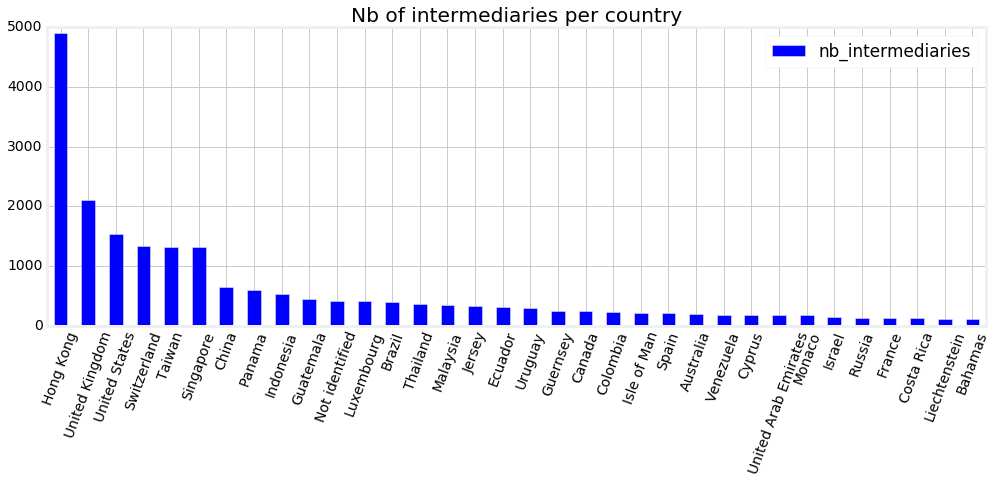

In [11]:
data = mldb.query("""
SELECT horizontal_sum({*}) as nb_intermediaries
FROM transpose((
    SELECT tokenize(countries, {splitchars: ';'}) AS *
    FROM intermediaries
    WHERE countries IS NOT NULL
))
WHERE horizontal_sum({*}) > 100
ORDER BY nb_intermediaries DESC
""")
bar_plot(data, 'Nb of intermediaries per country')

## Officers

Now let's have a look at the Officers' data, the owners being the offshore entities.

In [12]:
print mldb.post("/v1/procedures", {
    "type": 'import.text',
    "params": {
        "dataFileUrl": data_dir + 'Officers.csv.gz',
        "delimiter": ',',
        "encoding": 'latin1',
        "runOnCreation": True,
        "outputDataset": 'officers',
        "ignoreBadLines": True
    }
})

<Response [201]>


In [13]:
mldb.query('SELECT * FROM officers LIMIT 5')

,countries,country_codes,name,node_id,sourceID,valid_until
_rowName,,,,,,
318399,Not identified,XXX,Xu Ming Gang,66866,Offshore Leaks,The Offshore Leaks data is current through 2010
318400,Not identified,XXX,Indo-East Engineering & Construction Pte Ltd,66867,Offshore Leaks,The Offshore Leaks data is current through 2010
318401,Not identified,XXX,Great State Development Limited,66868,Offshore Leaks,The Offshore Leaks data is current through 2010
318402,Cayman Islands,CYM,Hong Kong Bank International Trustee Limited -...,45097,Offshore Leaks,The Offshore Leaks data is current through 2010
318403,Hong Kong,HKG,"CHEN Chia Long, Carlos ???",45098,Offshore Leaks,The Offshore Leaks data is current through 2010


And we also need all the links between those officers. The next dataset actually contains links between everything we have loaded so far. They are called "edges" as edges in a [graph][1], and our entities/intermediaries/officers are the nodes of the graph. 
[1]:https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)

In [14]:
print mldb.post("/v1/procedures", {
    "type": 'import.text',
    "params": {
        "dataFileUrl": data_dir + 'all_edges.csv.gz',
        "delimiter": ',',
        "encoding": 'latin1',
        "runOnCreation": True,
        "outputDataset": 'edges',
        "ignoreBadLines": True,
        "select": "* EXCLUDING (rel_type), lower(rel_type) AS rel_type"
    }
})

<Response [201]>


In [15]:
mldb.query('SELECT * FROM edges LIMIT 5')

,node_1,node_2,rel_type
_rowName,,,
2,11000001,10208879,intermediary of
3,11000001,10198662,intermediary of
4,11000001,10159927,intermediary of
5,11000001,10165779,intermediary of
6,11000001,10152967,intermediary of


Let's explore a bit and list the main type of links in the graph.

In [16]:
mldb.query("""
SELECT count(*) AS count
NAMED rel_type
FROM edges
GROUP BY rel_type
ORDER BY count DESC
LIMIT 20
""")

,count
_rowName,
shareholder of,382788
intermediary of,319121
registered address,316472
director of,118589
similar name and address as,46761
records & registers of,36318
beneficiary of,19182
secretary of,14351
same name and registration date as,3146


We can then use those links to see for example what officers are shareholders of what offshore entities, using a simple [`JOIN`][0]. We can then filter to keep only the "[the bearer][1]" (or "el portador" in Spanish) kind of shareholders. Those are the most secretive ones, not keeping track of who is really behind the shares. Finally we group those by the country of the offshore company and by year.
[0]: ../../../../doc/#builtin/sql/FromExpression.md.html
[1]: https://en.wikipedia.org/wiki/Bearer_instrument

In [17]:
data = mldb.query("""
SELECT count(*) as count, country, year
FROM (
  SELECT en.jurisdiction_description as country, date_part('year', en.incorporation_date) as year, en.jurisdiction
  FROM edges as e
  JOIN officers as o
    ON o.node_id = e.node_1
  JOIN entities as en
    ON en.node_id = e.node_2
  WHERE ((lower(o.name) LIKE '%the bearer%') OR (lower(o.name) LIKE '%el portador%'))
        AND e.rel_type = 'shareholder of'
        AND (en.jurisdiction != 'XXX')
)
GROUP BY country, year""")

In [18]:
hover = HoverTool(tooltips=[("year", "$x"),("count", "$y"),("country", "@country")])
line = Line(data, x='year', y='count', color='country', legend='top_left', width=1000, tools=[hover],
            title='Number of "bearer" shareholders per offshore jurisdictions')
show(line)

You can clearly see when the British Virgin Islands started to add more regulation on bearer shares, and when they switched to other countries.

## Conclusion

This was a quick overview of how we can use MLDB to explore data, using its powerful yet simple SQL-like interface. You can find more advanced uses of MLDB in our other [demos and tutorials][1].

[1]: ../../../../doc/#builtin/Demos.md.html